### **Imports**

In [23]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### **Data Loading and Parsing Functions**

In [24]:
def load_history(file_path):
    """Load JSON data from a file."""
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

def parse_record(record):
    """
    Parse an individual record.
    Accept only entries whose "title" starts with "Watched" and which do not have a detail named "From Google Ads".
    """
    # Filter out records with "From Google Ads" details
    if "details" in record:
        for detail in record["details"]:
            if detail.get("name", "").strip() == "From Google Ads":
                return None
    title = record.get("title", "")
    if not title.startswith("Watched"):
        return None
    time_str = record.get("time")
    try:
        # Convert the ISO 8601 string to a timezone-aware datetime (the "Z" will produce a UTC-aware timestamp)
        dt = pd.to_datetime(time_str)
    except Exception:
        return None
    return {"datetime": dt, "title": title}

def load_and_parse_histories(watch_file, search_file):
    """Load and combine records from watch and search history files."""
    watch_data = load_history(watch_file)
    search_data = load_history(search_file)
    records = []
    for rec in watch_data:
        parsed = parse_record(rec)
        if parsed:
            records.append(parsed)
    for rec in search_data:
        parsed = parse_record(rec)
        if parsed:
            records.append(parsed)
    return records

### **Sleep Estimation Function**

In [25]:
def estimate_sleep_periods(df, threshold_hours=5):
    """
    Estimate sleep periods by detecting gaps between successive events longer than threshold_hours.
    For each gap, record the last event before the gap and the first event after the gap.
    """
    df_sorted = df.sort_values("datetime").reset_index(drop=True)
    df_sorted["time_diff"] = df_sorted["datetime"].diff()
    threshold = pd.Timedelta(hours=threshold_hours)
    sleep_periods = []
    for i in range(1, len(df_sorted)):
        if df_sorted.loc[i, "time_diff"] > threshold:
            sleep_start = df_sorted.loc[i - 1, "datetime"]
            sleep_end   = df_sorted.loc[i, "datetime"]
            duration = sleep_end - sleep_start
            sleep_periods.append({
                "sleep_start": sleep_start,
                "sleep_end": sleep_end,
                "duration": duration,
                "final_video_hour": sleep_start.hour + sleep_start.minute/60 + sleep_start.second/3600,
                "first_video_hour": sleep_end.hour + sleep_end.minute/60 + sleep_end.second/3600
            })
    return pd.DataFrame(sleep_periods)

### **Day-Level Aggregation Functions**

In [26]:
def compute_estimated_durations(events):
    """
    Given a DataFrame 'events' for one day interval sorted by datetime, compute the gap between consecutive events.
    Each gap is capped at a maximum of 15 minutes (900 seconds) so that an unusually long pause does not inflate the metric.
    Returns a list of estimated durations (in seconds) for each inter-event gap.
    """
    cap_seconds = 900  # 15 minutes in seconds
    durations = []
    times = events["datetime"].tolist()
    for i in range(len(times)-1):
        gap_sec = (times[i+1] - times[i]).total_seconds()
        durations.append(min(gap_sec, cap_seconds))
    return durations

def aggregate_day_metrics(df, sleep_df):
    """
    Define day intervals based on consecutive sleep_end times (sleep_end indicates the start of a day).
    For each day interval (from one sleep_end to the next), aggregate metrics:
      - total videos watched (all events in that interval),
      - estimated total time spent on YouTube (sum of capped inter-event durations),
      - average estimated duration (average of those gaps),
      - video length differential: difference between the first estimated duration and the last estimated duration.
    """
    sleep_end_times = sorted(sleep_df["sleep_end"])
    day_records = []
    # Create day intervals from sleep_end times
    for i in range(1, len(sleep_end_times)):
        day_start = sleep_end_times[i-1]
        day_end = sleep_end_times[i]
        subset = df[(df["datetime"] >= day_start) & (df["datetime"] < day_end)].sort_values("datetime")
        if subset.empty:
            continue
        total_videos = len(subset)
        durations = compute_estimated_durations(subset)
        total_time = sum(durations) if durations else 0
        avg_duration = total_time / len(durations) if durations else 0
        # Use first and last estimated durations for the differential (if available)
        if durations:
            first_duration = durations[0]
            last_duration = durations[-1]
            length_diff = first_duration - last_duration
        else:
            length_diff = 0
        day_records.append({
            "day_start": day_start,
            "day_end": day_end,
            "total_videos": total_videos,
            "total_time": total_time,          # in seconds
            "avg_duration": avg_duration,      # in seconds
            "length_diff": length_diff
        })
    return pd.DataFrame(day_records)

def aggregate_weekly(day_df, overall_start):
    """
    Group the day-level metrics into weeks (using the day_start relative to an overall start date).
    """
    day_df = day_df.copy()
    day_df["week_index"] = day_df["day_start"].apply(lambda x: (x - overall_start).days // 7)
    weekly = day_df.groupby("week_index").agg({
        "total_videos": "sum",
        "total_time": "sum",
        "avg_duration": "mean",
        "length_diff": "mean"
    }).reset_index()
    return weekly

def aggregate_sleep_by_week(sleep_df, overall_start):
    """
    Group sleep boundary metrics (final and first video hours) by week.
    """
    sleep_df = sleep_df.copy()
    sleep_df["week_index"] = sleep_df["sleep_start"].apply(lambda x: (x - overall_start).days // 7)
    weekly = sleep_df.groupby("week_index").agg({
        "final_video_hour": "mean",
        "first_video_hour": "mean"
    }).reset_index()
    return weekly

def aggregate_sleep_by_day(sleep_df, start_date, end_date):
    """
    For a given period (e.g., the last month), group sleep boundary records by day.
    """
    sleep_day = sleep_df[(sleep_df["sleep_start"] >= start_date) & (sleep_df["sleep_start"] <= end_date)].copy()
    sleep_day["day"] = sleep_day["sleep_start"].dt.date
    daily = sleep_day.groupby("day").agg({
        "final_video_hour": "mean",
        "first_video_hour": "mean"
    }).reset_index()
    return daily

### **Main Analysis and Plotting**

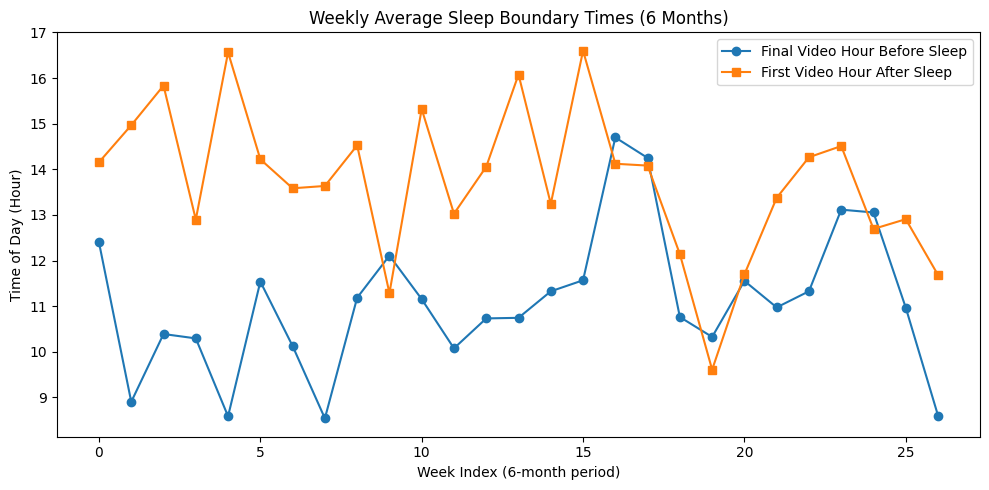

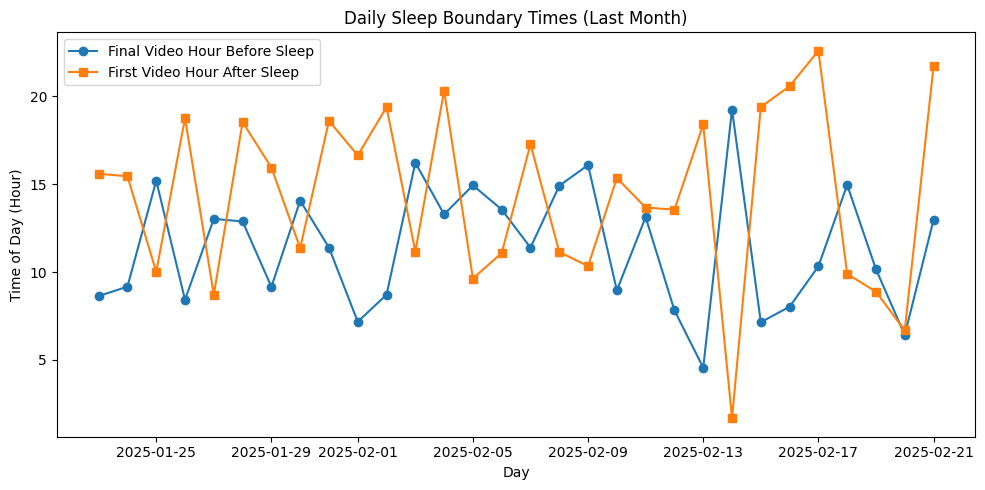

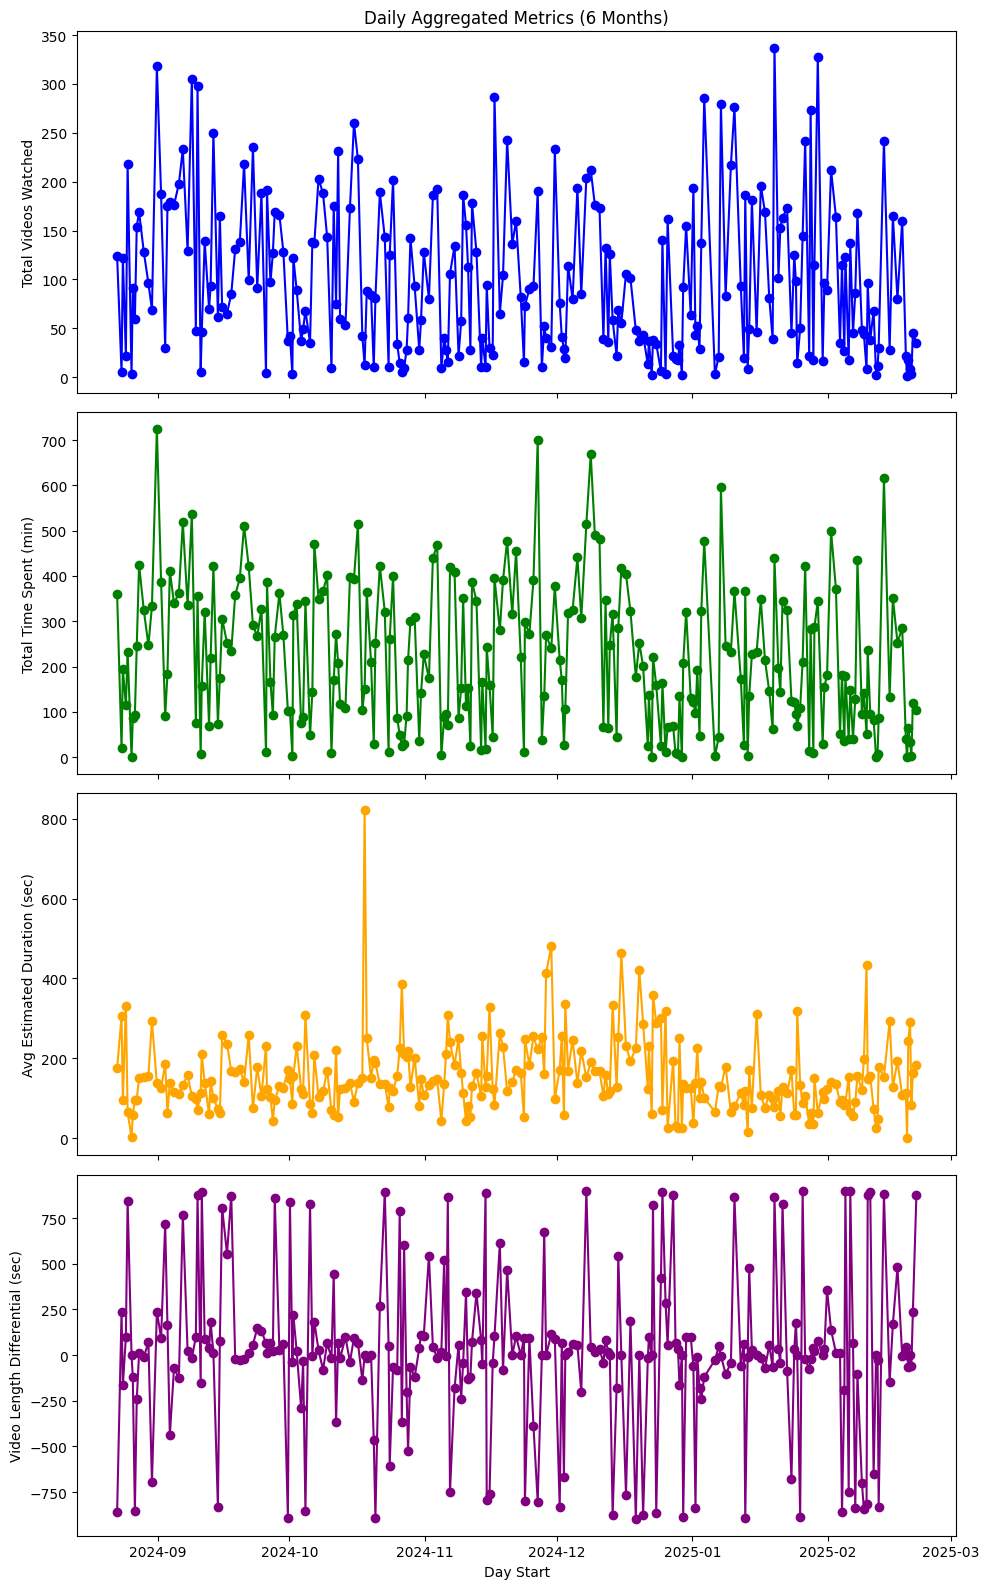

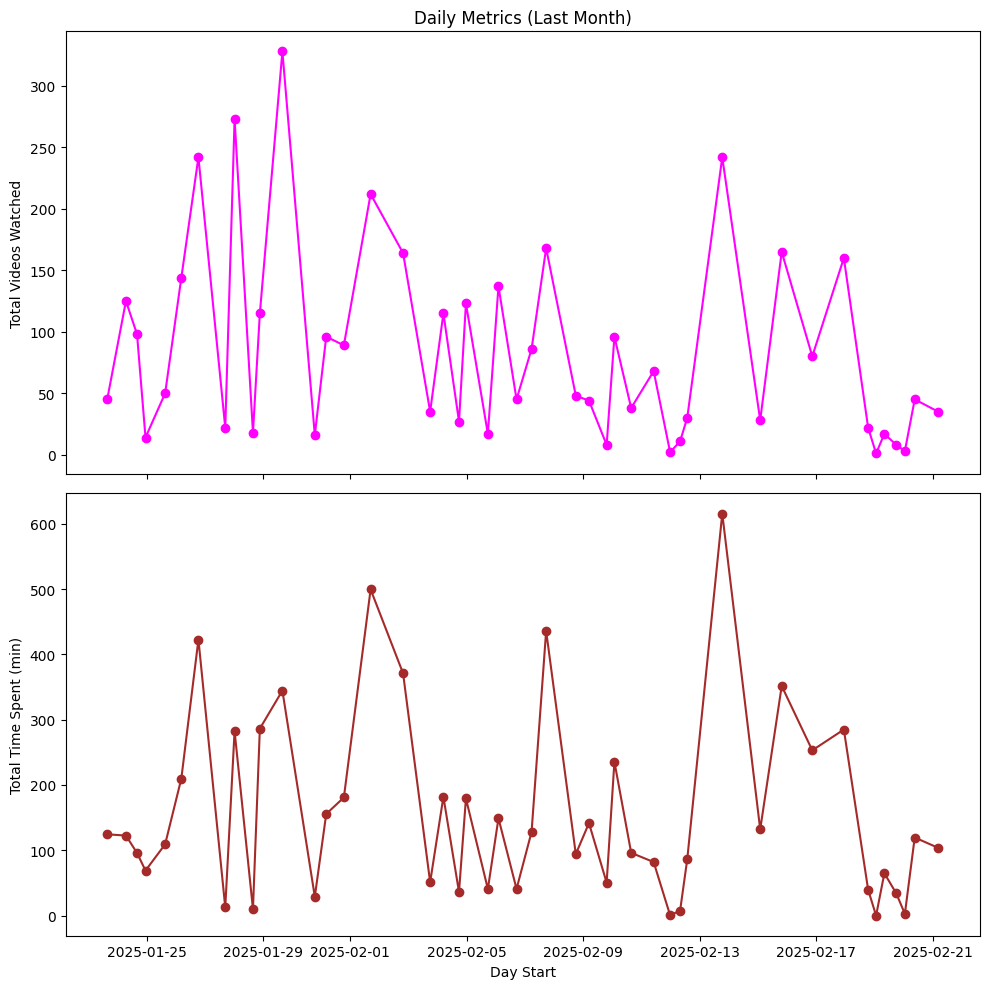

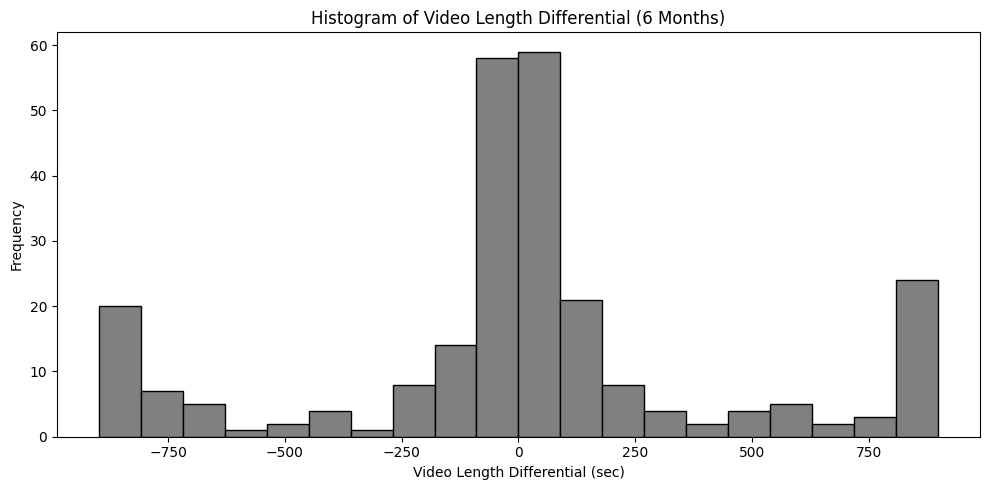

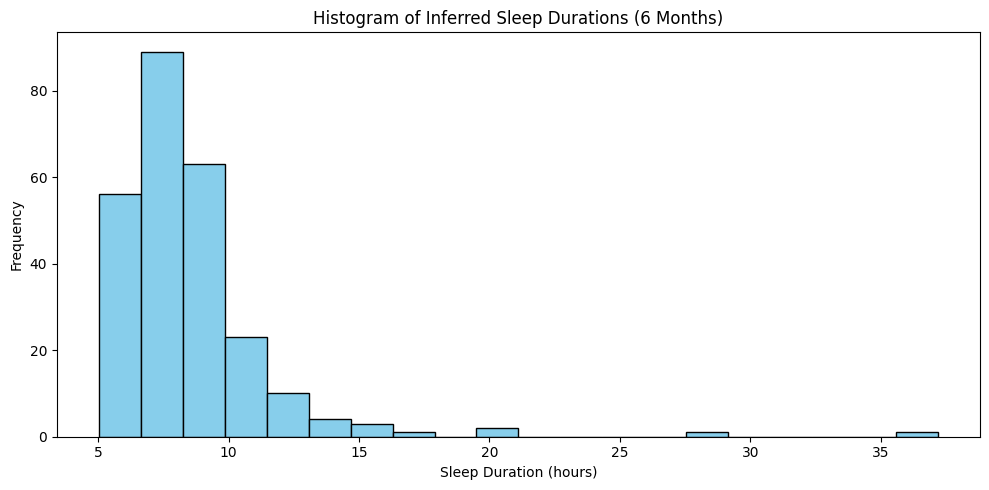

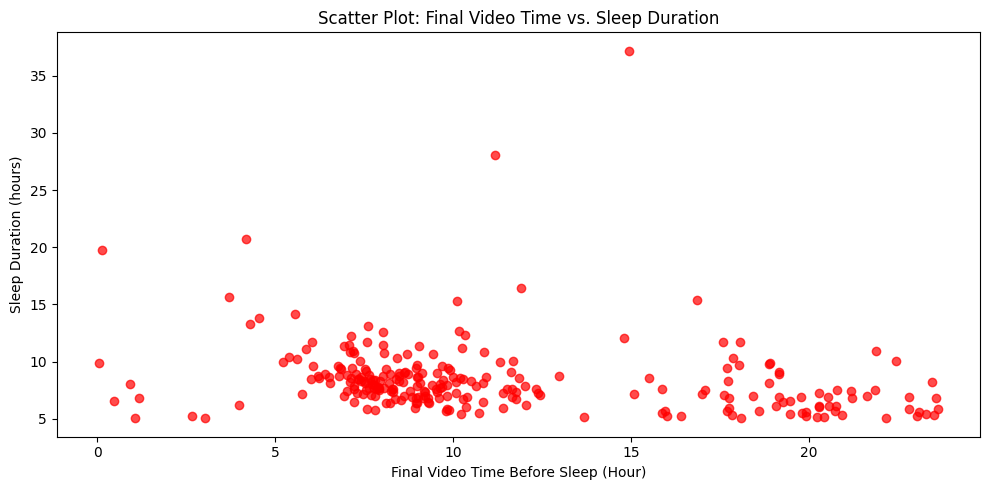

In [27]:
def main():
    # Define file paths (ensure the JSON files are in the folder "history")
    watch_file = os.path.join("history", "watch-history.json")
    search_file = os.path.join("history", "search-history.json")
    
    # Load and parse records from the history files
    records = load_and_parse_histories(watch_file, search_file)
    if not records:
        print("No valid records found.")
        return
    df = pd.DataFrame(records)
    
    # Filter the data to the target 6-month period: Aug 22, 2024 to Feb 22, 2025.
    start_range = pd.to_datetime("2024-08-22").tz_localize("UTC")
    end_range = pd.to_datetime("2025-02-22").tz_localize("UTC")
    df = df[(df["datetime"] >= start_range) & (df["datetime"] <= end_range)].reset_index(drop=True)
    df.sort_values("datetime", inplace=True)
    
    # Estimate sleep periods using a threshold of 5 hours of inactivity
    sleep_df = estimate_sleep_periods(df, threshold_hours=5)
    if sleep_df.empty:
        print("No sleep periods detected.")
        return
    
    # Aggregate day-level metrics using sleep_end (which indicates the start of a new day)
    day_df = aggregate_day_metrics(df, sleep_df)
    if day_df.empty:
        print("No day metrics computed.")
        return
    
    # Overall start of our data is the start_range
    overall_start = start_range
    weekly_day = aggregate_weekly(day_df, overall_start)
    weekly_sleep = aggregate_sleep_by_week(sleep_df, overall_start)
    
    # Define the "last month" as the final 30 days within our period
    last_month_start = end_range - pd.Timedelta(days=30)
    daily_sleep_last_month = aggregate_sleep_by_day(sleep_df, last_month_start, end_range)
    last_month_day_df = day_df[(day_df["day_start"] >= last_month_start) & (day_df["day_start"] <= end_range)]

    ###############################
    # Generate Graphs and Save Figures
    ###############################
    
    ## Graph 1: Weekly sleep boundary times for the 6-month period (~24 data points)
    fig1, ax1 = plt.subplots(figsize=(10, 5))
    ax1.plot(weekly_sleep["week_index"], weekly_sleep["final_video_hour"],
             marker="o", label="Final Video Hour Before Sleep")
    ax1.plot(weekly_sleep["week_index"], weekly_sleep["first_video_hour"],
             marker="s", label="First Video Hour After Sleep")
    ax1.set_xlabel("Week Index (6-month period)")
    ax1.set_ylabel("Time of Day (Hour)")
    ax1.set_title("Weekly Average Sleep Boundary Times (6 Months)")
    ax1.legend()
    plt.tight_layout()
    fig1.savefig("weekly_sleep_times_6m.png")
    plt.show()
    
    ## Graph 2: Daily sleep boundary times over the last month (~30 data points)
    fig2, ax2 = plt.subplots(figsize=(10, 5))
    ax2.plot(daily_sleep_last_month["day"], daily_sleep_last_month["final_video_hour"],
             marker="o", label="Final Video Hour Before Sleep")
    ax2.plot(daily_sleep_last_month["day"], daily_sleep_last_month["first_video_hour"],
             marker="s", label="First Video Hour After Sleep")
    ax2.set_xlabel("Day")
    ax2.set_ylabel("Time of Day (Hour)")
    ax2.set_title("Daily Sleep Boundary Times (Last Month)")
    ax2.legend()
    plt.tight_layout()
    fig2.savefig("daily_sleep_times_last_month.png")
    plt.show()
    
    ## Graph 3: Daily aggregated metrics for the 6-month period
    fig3, axs3 = plt.subplots(4, 1, figsize=(10, 16), sharex=True)
    axs3[0].plot(day_df["day_start"], day_df["total_videos"], marker="o", color="blue")
    axs3[0].set_ylabel("Total Videos Watched")
    axs3[0].set_title("Daily Aggregated Metrics (6 Months)")
    
    axs3[1].plot(day_df["day_start"], day_df["total_time"] / 60, marker="o", color="green")
    axs3[1].set_ylabel("Total Time Spent (min)")
    
    axs3[2].plot(day_df["day_start"], day_df["avg_duration"], marker="o", color="orange")
    axs3[2].set_ylabel("Avg Estimated Duration (sec)")
    
    axs3[3].plot(day_df["day_start"], day_df["length_diff"], marker="o", color="purple")
    axs3[3].set_ylabel("Video Length Differential (sec)")
    axs3[3].set_xlabel("Day Start")
    
    plt.tight_layout()
    fig3.savefig("daily_metrics_6m.png")
    plt.show()
    
    ## Graph 4: Daily metrics for the last month
    fig4, axs4 = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    axs4[0].plot(last_month_day_df["day_start"], last_month_day_df["total_videos"],
                 marker="o", color="magenta")
    axs4[0].set_ylabel("Total Videos Watched")
    axs4[0].set_title("Daily Metrics (Last Month)")
    
    axs4[1].plot(last_month_day_df["day_start"], last_month_day_df["total_time"] / 60,
                 marker="o", color="brown")
    axs4[1].set_ylabel("Total Time Spent (min)")
    axs4[1].set_xlabel("Day Start")
    
    plt.tight_layout()
    fig4.savefig("daily_metrics_last_month.png")
    plt.show()
    
    ## Graph 5: Histogram for video length differential over 6 months
    fig5, ax5 = plt.subplots(figsize=(10, 5))
    ax5.hist(day_df["length_diff"], bins=20, color="gray", edgecolor="black")
    ax5.set_xlabel("Video Length Differential (sec)")
    ax5.set_ylabel("Frequency")
    ax5.set_title("Histogram of Video Length Differential (6 Months)")
    plt.tight_layout()
    fig5.savefig("video_length_diff_hist_6m.png")
    plt.show()
    
    ## Graph 6: Histogram of inferred sleep durations (in hours)
    fig6, ax6 = plt.subplots(figsize=(10, 5))
    durations_hours = sleep_df["duration"].dt.total_seconds() / 3600
    ax6.hist(durations_hours, bins=20, color="skyblue", edgecolor="black")
    ax6.set_xlabel("Sleep Duration (hours)")
    ax6.set_ylabel("Frequency")
    ax6.set_title("Histogram of Inferred Sleep Durations (6 Months)")
    plt.tight_layout()
    fig6.savefig("sleep_duration_hist_6m.png")
    plt.show()
    
    ## Graph 7: Scatter plot of final video time (before sleep) vs. sleep duration (in hours)
    fig7, ax7 = plt.subplots(figsize=(10, 5))
    ax7.scatter(sleep_df["final_video_hour"], durations_hours, color="red", alpha=0.7)
    ax7.set_xlabel("Final Video Time Before Sleep (Hour)")
    ax7.set_ylabel("Sleep Duration (hours)")
    ax7.set_title("Scatter Plot: Final Video Time vs. Sleep Duration")
    plt.tight_layout()
    fig7.savefig("final_time_vs_sleep_duration.png")
    plt.show()

if __name__ == "__main__":
    main()